In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler
import seaborn as sns
from scipy.stats import norm, lognorm

In [49]:
sns.set_theme()
beta_true = [.10, .1, .2]# [0.03, 0.17, 0.07]
alpha = 0.1
gamma = 0.05
prior_mu = -3
prior_sigma = 1
n_zones = 2
N = 100
T = 52
K = 30

In [50]:
si_model = SIModel(alpha, gamma, beta_true, n_zones,
                   prior_mu, prior_sigma, N, T, summarize=False)
x_o_raw = si_model.get_observed_data(29)

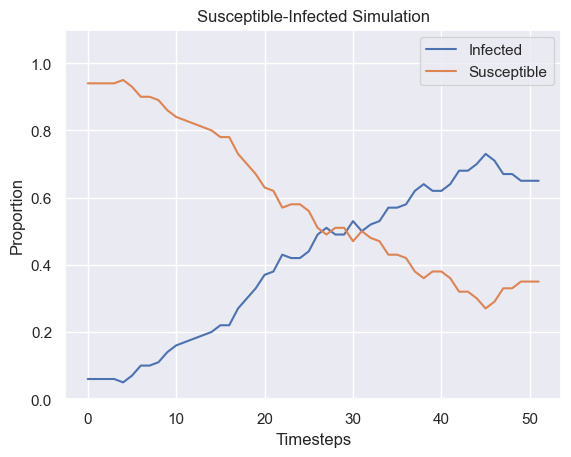

In [51]:
I_o = np.array(x_o_raw[0])
S_o  = 1 - I_o
plt.plot(I_o, label="Infected")
plt.plot(S_o, label="Susceptible")
plt.legend(loc="upper right")
plt.xlabel("Timesteps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation")
plt.show()

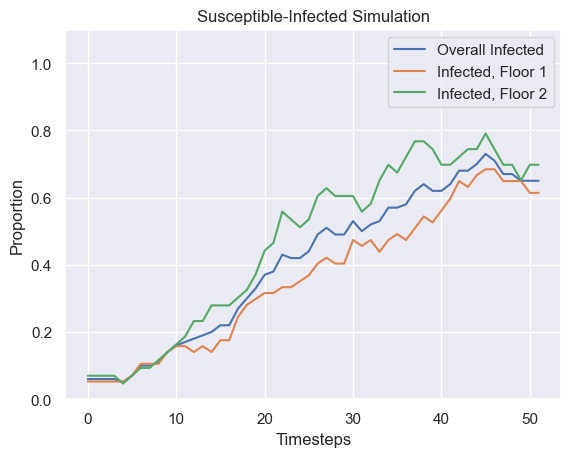

In [54]:
F1 = np.array(x_o_raw[1])
F2  = np.array(x_o_raw[2])
plt.plot(I_o, label="Overall Infected")
plt.plot(F1, label="Infected, Floor 1")
plt.plot(F2, label="Infected, Floor 2")
plt.legend(loc="upper right")
plt.xlabel("Timesteps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation")
plt.show()

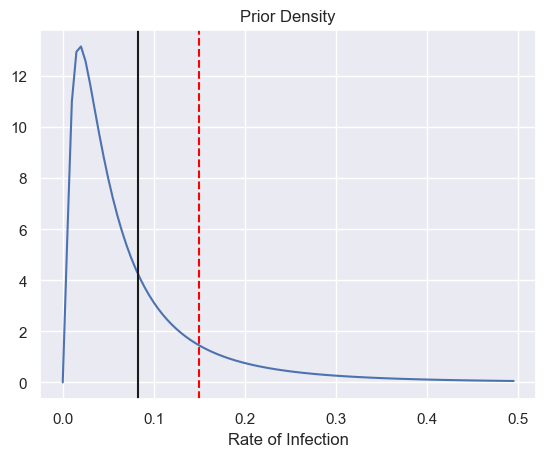

In [26]:
# visualize prior
prior_mu = -3
prior_sigma = 1
np.random.seed(10)
x = np.arange(0, 0.5, 0.005)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma))
ax.set_xlabel("Rate of Infection")
ax.set_title(f"Prior Density")
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
plt.axvline(prior_mean, color="k")
plt.axvline(beta_true, color="red", linestyle="--")
plt.show()

A reasonably well-calibrated prior: $P(\beta > \beta^*) = 0.15$.

### Prior Predictive Check

In [59]:
(n_zones+1)*K

90

In [64]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=(K, n_zones+1), random_state=2))
prior_predictive = np.empty((K, T))

In [66]:
x_o_raw[0]

tensor([0.0600, 0.0600, 0.0600, 0.0600, 0.0500, 0.0700, 0.1000, 0.1000, 0.1100,
        0.1400, 0.1600, 0.1700, 0.1800, 0.1900, 0.2000, 0.2200, 0.2200, 0.2700,
        0.3000, 0.3300, 0.3700, 0.3800, 0.4300, 0.4200, 0.4200, 0.4400, 0.4900,
        0.5100, 0.4900, 0.4900, 0.5300, 0.5000, 0.5200, 0.5300, 0.5700, 0.5700,
        0.5800, 0.6200, 0.6400, 0.6200, 0.6200, 0.6400, 0.6800, 0.6800, 0.7000,
        0.7300, 0.7100, 0.6700, 0.6700, 0.6500, 0.6500, 0.6500])

In [71]:
prior_sample[0]

array([0.03281867, 0.04706306, 0.00588001])

In [75]:
len(si_model.beta_true)

3

In [76]:
si_model.d_theta

3

In [73]:
si_model.d_theta

3

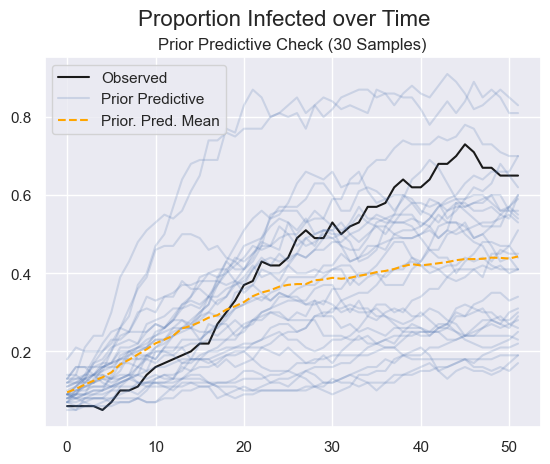

In [77]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=(K, n_zones+1), random_state=2))
prior_predictive = np.empty((K, T))

for i in range(K):
    si_model = SIModel(alpha, gamma, prior_sample[i], 
                   2, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    prior_predictive[i] =  np.array(x_rep[0])
prp_mean = prior_predictive.mean(0)

labels = ["Prior Predictive"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(prp_mean, label="Prior. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.suptitle("Proportion Infected over Time", fontsize=16)
plt.title("Prior Predictive Check (30 Samples)")
plt.show()

## ABC

In [ ]:
#TODO: get a sense of error spreads to scale epsilon

In [80]:
si_model = SIModel(alpha, gamma, beta_true, 
                   prior_mu, prior_sigma, n_zones, 
                   N, T, summarize=True)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)

Time lapsed: 19.81 seconds
With tolerance 0.0001, acceptance rate: 0.013904
Total number of attempts: 7,192


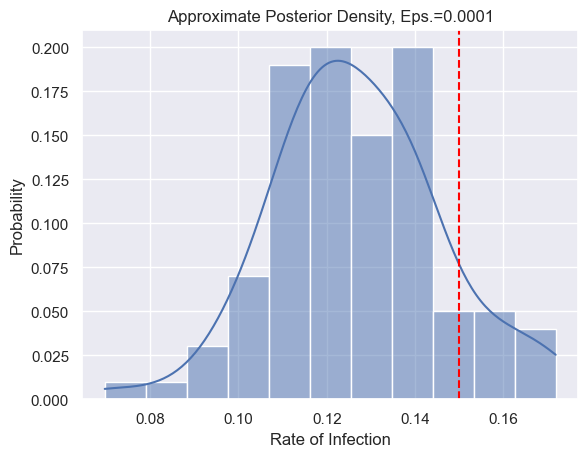

In [82]:
S = 100
epsilon = 0.0001
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=50000
    )
ax = sns.histplot(np.exp(posterior_sample), stat="probability", kde=True)
ax.set_xlabel("Rate of Infection")
ax.set_title(f"Approximate Posterior Density, Eps.={epsilon}")
plt.axvline(beta_true, color="red", linestyle="--")
plt.show()

### NPE

Hyperparameters: 1024 observations, network dimension 8, 400 training epochs

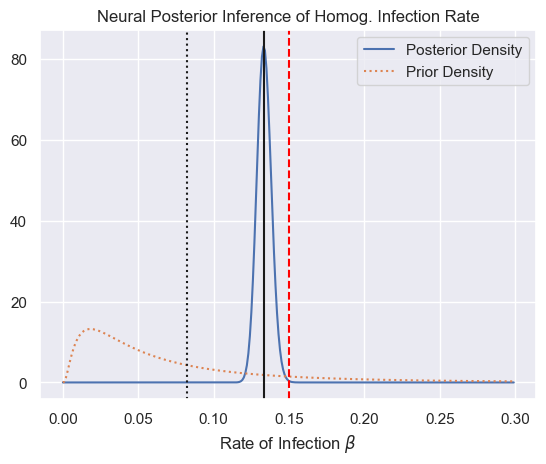

In [73]:
# mu = -2.272
# sigma = 0.143
mu = - 2.0145
sigma = 0.036
np.random.seed(10)
x = np.arange(0., 0.3, 0.001)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Posterior Density")
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(f"Neural Posterior Inference of Homog. Infection Rate")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":")
plt.axvline(posterior_mean, color="k")
plt.axvline(beta_true, color="red", linestyle="--", label="True")
plt.show()

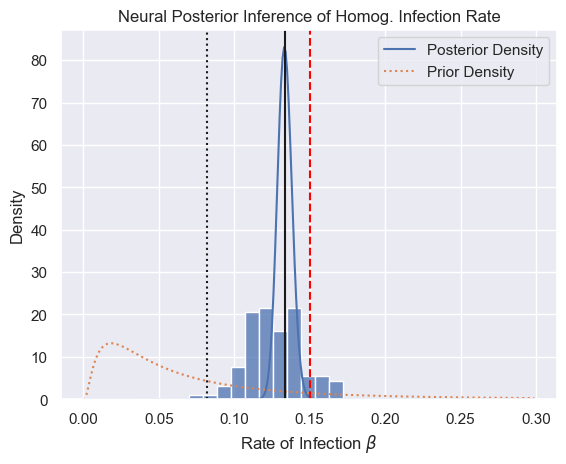

In [83]:
mu = - 2.0145
sigma = 0.036
np.random.seed(10)
x = np.arange(0., 0.3, 0.001)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Posterior Density")
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
ax2 = sns.histplot(np.exp(posterior_sample), stat="density")
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(f"Neural Posterior Inference of Homog. Infection Rate")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":")
plt.axvline(posterior_mean, color="k")
plt.axvline(beta_true, color="red", linestyle="--", label="True")
plt.show()

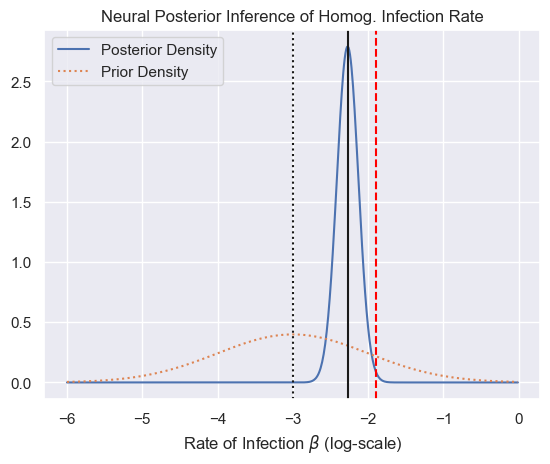

In [41]:
mu = -2.272
sigma = 0.143
np.random.seed(10)
x = np.arange(-6., 0, 0.01)
ax = sns.lineplot(x=x, y=norm.pdf(x, mu, sigma), label="Posterior Density")
ax1 = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma), 
                   label="Prior Density", linestyle=":")
ax.set_xlabel(r"Rate of Infection $\beta$ (log-scale)")
ax.set_title(f"Neural Posterior Inference of Homog. Infection Rate")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mu, color="k", linestyle=":")
plt.axvline(mu, color="k")
plt.axvline(np.log(beta_true), color="red", linestyle="--", label="True")
plt.show()

## Posterior Predictive Checks

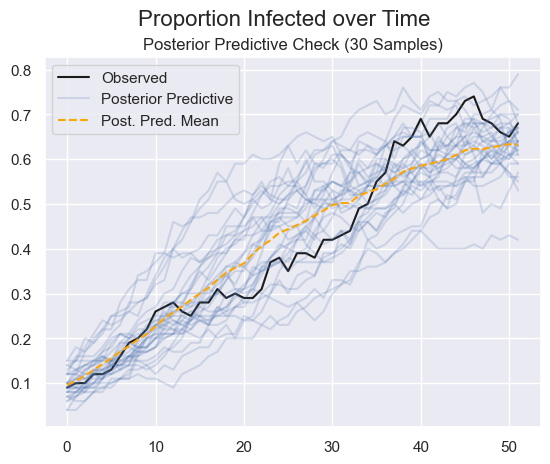

In [85]:
neural_posterior = norm(mu, sigma)
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, T))


for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   prior_mu, prior_sigma, n_zones, 
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)

labels = ["Posterior Predictive"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.suptitle("Proportion Infected over Time", fontsize=16)
plt.title("Posterior Predictive Check (30 Samples)")
plt.show()

In [70]:
autocorrs = np.empty(K)
means = np.empty(K)
sds = np.empty(K)
for i in range(K):
    A = posterior_predictive[i]
    means[i] = A.mean()
    autocorrs[i] = np.correlate(A[1:], A[:-1])
    sds[i] = A.std()

/var/folders/sk/4ngl_8x117n6zr60rtkvrr300000gn/T/ipykernel_82038/3851023876.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  autocorrs[i] = np.correlate(A[1:], A[:-1])


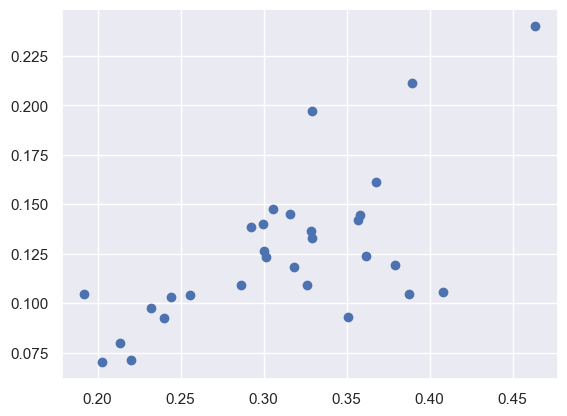

In [72]:
plt.scatter(x = means, y = sds)

In [56]:
autocorrs

array([ 5.38159995,  5.85059995,  2.33350002,  9.98380011,  6.42089993,
        7.44359982,  5.27109997,  3.8743001 ,  3.36430001,  5.8276    ,
        5.41339989,  7.41320022,  9.1015998 ,  6.75329987,  7.61129994,
        3.55019999,  4.70880001, 13.84540007,  6.43909996,  8.08109984,
        2.7339    ,  2.42950006,  7.48529998,  2.59679999,  5.51639997,
        6.14179998,  8.22179987,  6.01619995,  8.16699995,  3.19750002])

In [57]:
means

array([0.3       , 0.31807692, 0.2025    , 0.38923077, 0.32826923,
       0.36153846, 0.2925    , 0.25557693, 0.24      , 0.30557692,
       0.30153846, 0.32903847, 0.40807692, 0.35076923, 0.35826923,
       0.24403846, 0.28615385, 0.46346154, 0.32903846, 0.37923077,
       0.22      , 0.19192308, 0.35673077, 0.21326923, 0.29961538,
       0.31576923, 0.38730769, 0.32596154, 0.36769231, 0.23211539])